<center><img src="https://images.squarespace-cdn.com/content/v1/5d5ebe0290b74100011fd096/1596042157547-KXGXKTJQ4KH2DDXM5726/FourthBrain%28noDescritor%29Logo.png?format=1500w" width=200 height=200 /></center>

# 3D-Packing Datasets

## Pre-requisites

In [22]:
import sys
sys.path.append("/home/nguyens/Documents/3D-Packing/src/") # replace with your path

<IPython.core.display.Javascript object>

## Check libraries

In [23]:
#!pip install loguru
#!pip install ortools
#!pip install rectpack
#!pip install nb_black

<IPython.core.display.Javascript object>

In [24]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

import config_2D, config_3D, dataset_2D, dataset_3D, utils_2D, utils_3D
%matplotlib inline

<IPython.core.display.Javascript object>

In [25]:
%load_ext autoreload
%load_ext nb_black
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [26]:
plt.style.use("seaborn")
np.random.seed(config_2D.RANDOM_SEED)

<IPython.core.display.Javascript object>

## Containers

Container ISO:

|   |  $L\times W\times H (cm)$  | Load (kg) |
|:-:|:--------------------------:|:--------:|
| 1A | $233\times 1200\times 220$ |  $26480$ |
| 1C |  $233\times 587\times 220$ |  $28180$ |


## 2D Dataset

### Products

In [7]:
product_dataset2d = dataset_2D.ProductDataset2D(
    "../data/products_2D.pkl", # save dataset to directory
    config_2D.NUM_PRODUCTS, # 1e6
    config_2D.MIN_PRODUCT_WIDTH,
    config_2D.MAX_PRODUCT_WIDTH,
    config_2D.MIN_PRODUCT_HEIGHT,
    config_2D.MAX_PRODUCT_HEIGHT,
    force_overload=True, # Generate new dataset
)
print("Dimensions are in cm and liter:")
product_dataset2d.products.head()


Dimensions are in cm and liter:


width  height  volume
0     20      21     4.2
1     27      30     8.1
2     20      20     4.0
3    120      66    79.2
4    120      49    58.8

<IPython.core.display.Javascript object>

Dataset module produced the set of boxed with random size and volume is proportional with area. Let's check the result from export pickle file from directory:

In [7]:
dataset_data_2d = pd.read_pickle("../data/products_2D.pkl")
dataset_data_2d.head()

width  height  volume
0     20      21     4.2
1     27      30     8.1
2     20      20     4.0
3    120      66    79.2
4    120      49    58.8

<IPython.core.display.Javascript object>

The local file seems to be inline with above dataframe from module.

Now let's show some statistical information of the datset:

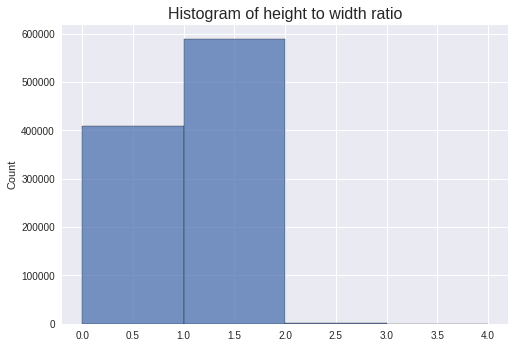

<IPython.core.display.Javascript object>

In [10]:
plt.figure()
sns.histplot(
    dataset_data_2d.height / dataset_data_2d.width,
    bins=np.arange(0, 5, 1),
)
plt.title("Histogram of height to width ratio", fontsize=16)
plt.show()


Most of the boxes has been created that have height over width ratio in range 1 to 2. Rare boxes have higher ratio than 2.

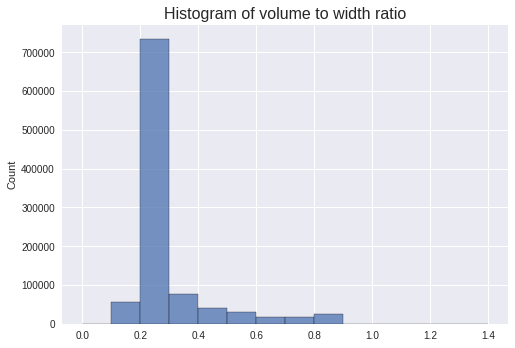

<IPython.core.display.Javascript object>

In [11]:
plt.figure()
sns.histplot(
    dataset_data_2d.volume / dataset_data_2d.width,
    bins=np.arange(0, 1.5, 0.1),
)
plt.title("Histogram of volume to width ratio", fontsize=16)
plt.show()

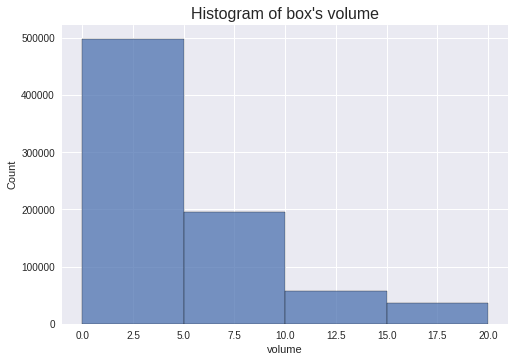

<IPython.core.display.Javascript object>

In [13]:
plt.figure()
sns.histplot(dataset_data_2d.volume, bins=np.arange(0, 25, 5))
plt.title("Histogram of box's volume", fontsize=16)
plt.show()


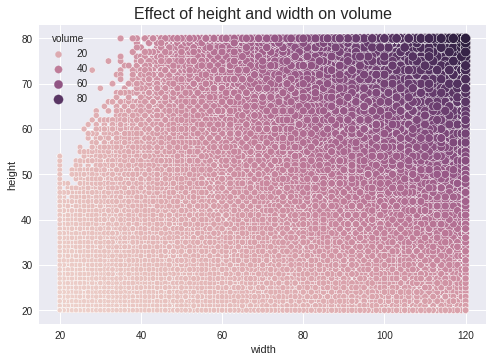

<IPython.core.display.Javascript object>

In [12]:
plt.figure()
sns.scatterplot(
    data=product_dataset2d.products,
    x="width",
    y="height",
    size="volume",
    hue="volume"
)
plt.title("Effect of height and width on volume", fontsize=16)
plt.show()


### Order

In [13]:
ordered_products = 100
order = product_dataset2d.get_order(ordered_products)
# order = pd.read_csv("data/test_order.csv")
# order = product_dataset.get_dummy_order(ordered_products)
order.head()

id  width  height  volume
0  847666     20      24     4.8
1  806505     20      20     4.0
2   26424     43      20     8.6
3  200498     24      20     4.8
4   91480     20      20     4.0

<IPython.core.display.Javascript object>

## 3D Dataset

In [7]:
product_dataset_3d = dataset_3D.ProductDataset3D(
    "../data/products_3D.pkl",
    config_3D.NUM_PRODUCTS,
    config_3D.MIN_PRODUCT_WIDTH,
    config_3D.MAX_PRODUCT_WIDTH,
    config_3D.MIN_PRODUCT_DEPTH,
    config_3D.MAX_PRODUCT_DEPTH,
    config_3D.MIN_PRODUCT_HEIGHT,
    config_3D.MAX_PRODUCT_HEIGHT,
    force_overload=True, # Generate new dataset
)
product_dataset_3d.products.head()

width  depth  height  volume
0     50     51      50  127.50
1     53     50      75  198.75
2     50     50      60  150.00
3     50     50      75  187.50
4     50     50      75  187.50

<IPython.core.display.Javascript object>

In [27]:
dataset_data_3d = pd.read_pickle("../data/products_3D.pkl")
dataset_data_3d.head()

width  depth  height  volume
0     50     51      50  127.50
1     53     50      75  198.75
2     50     50      60  150.00
3     50     50      75  187.50
4     50     50      75  187.50

<IPython.core.display.Javascript object>

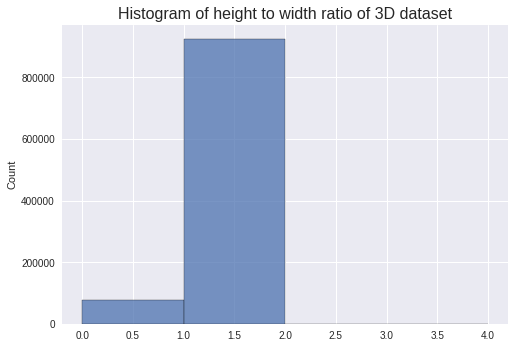

<IPython.core.display.Javascript object>

In [28]:
plt.figure()
sns.histplot(
    dataset_data_3d.height / dataset_data_3d.width,
    bins=np.arange(0, 5, 1),
)
plt.title("Histogram of height to width ratio of 3D dataset", fontsize=16)
plt.show()

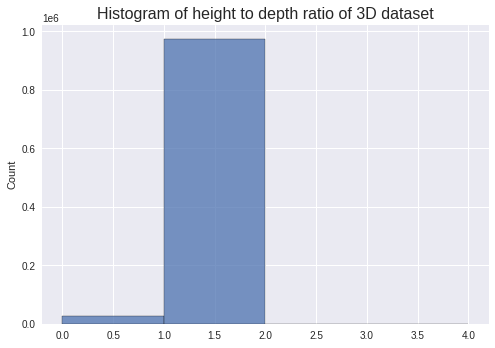

<IPython.core.display.Javascript object>

In [29]:
plt.figure()
sns.histplot(
    dataset_data_3d.height / dataset_data_3d.depth,
    bins=np.arange(0, 5, 1),
)
plt.title("Histogram of height to depth ratio of 3D dataset", fontsize=16)
plt.show()


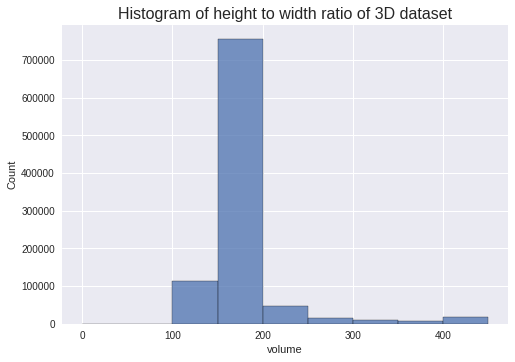

<IPython.core.display.Javascript object>

In [30]:
plt.figure()
sns.histplot(
    dataset_data_3d.volume,
    bins=np.arange(0, 500, 50),
)
plt.title("Histogram of height to width ratio of 3D dataset", fontsize=16)
plt.show()

In [38]:
dataset_data_3d_1 = dataset_data_3d.copy()
dataset_data_3d_1["binvolume"] = pd.cut(dataset_data_3d_1["volume"], bins=[0, 150, 200, 450])


<IPython.core.display.Javascript object>

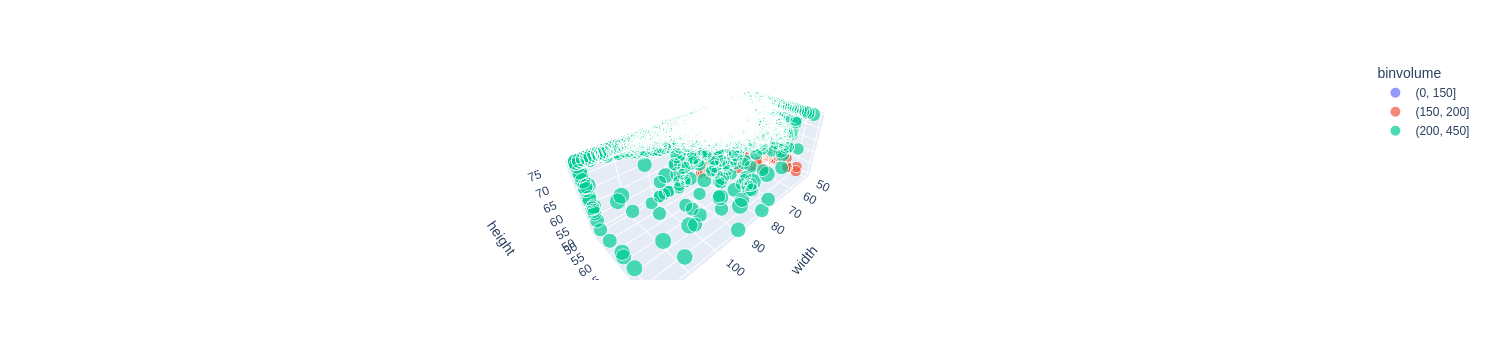

<IPython.core.display.Javascript object>

In [44]:
import plotly.express as px
fig = px.scatter_3d(
    dataset_data_3d_1.iloc[:50000,:],
    x="width", 
    y="depth", 
    z="height", 
    color="binvolume",
    size="volume"
)
fig.show()


<hr>